# Isotropic and Steerable NCA (structured seed experiments)

### Author: Craig Fouts (cwf2117@columbia.edu)

*Copyright 2023 Craig Fouts*

Licensed under the Apache License, Version 2.0 (the "License");
you may not use this file except in compliance with the License.
You may obtain a copy of the License at

[https://www.apache.org/licenses/LICENSE-2.0](https://www.apache.org/licenses/LICENSE-2.0)

Unless required by applicable law or agreed to in writing, software
distributed under the License is distributed on an "AS IS" BASIS,
WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
See the License for the specific language governing permissions and
limitations under the License.

In [1]:
#@title Notebook Utilities and Setup

import base64
import io
import matplotlib.pylab as pl
import numpy as np
import os
import PIL.Image, PIL.ImageDraw, PIL.ImageFont
import requests
import torch
import torch.nn.functional as F
import torchvision.models as models
import torchvision.transforms.functional as T
import warnings
from colorsys import hsv_to_rgb
# from google.colab import drive, output
from IPython.display import clear_output, Image
from torch.nn import BatchNorm1d, Dropout, InstanceNorm1d, LayerNorm, Module, ReLU, Sequential
from torchvision.transforms.functional_tensor import gaussian_blur
from tqdm.notebook import tnrange
from tqdm import tqdm

os.environ['FFMPEG_BINARY'] = 'ffmpeg'
import moviepy.editor as mvp
from moviepy.video.io.ffmpeg_writer import FFMPEG_VideoWriter

# output.enable_custom_widget_manager()

# * find GPU available
clear_output()
!nvidia-smi -L

# * sets the device
# *     defaults to 'cuda'
_DEVICE_ = 'cuda' if torch.cuda.is_available() else 'cpu'
print ('cuda available? ', torch.cuda.is_available())
print ('device: ', _DEVICE_)

torch.backends.cudnn.benchmark = True
torch.cuda.empty_cache()
torch.set_default_tensor_type('torch.cuda.FloatTensor')
warnings.filterwarnings('ignore')

# USE_DRIVE = False  #@param{type:"boolean"}
DIRECTORY = 'My Drive/Models'  #@param{type:"string"}
MODEL_PATH = '_models'

# if USE_DRIVE:
#   drive.mount('/content/drive')
#   MODEL_PATH = os.path.join('/content/drive', DIRECTORY)

def imread(url, max_size=None, mode=None):
  if url.startswith(('http:', 'https:')):
    headers = {'User-Agent': 'Requests in Colab/0.0 (https://colab.research.google.com/; no-reply@google.com) requests/0.0'}
    r = requests.get(url, headers=headers)
    f = io.BytesIO(r.content)
  else:
    f = url
  img = PIL.Image.open(f)
  if max_size is not None:
    img.thumbnail((max_size, max_size), PIL.Image.ANTIALIAS)
  if mode is not None:
    img = img.convert(mode)
  img = np.float32(img) / 255.
  return img

def np2pil(a):
  if a.dtype in (np.float32, np.float64):
    a = np.uint8(np.clip(a, 0, 1)*255)
  return PIL.Image.fromarray(a)

def imwrite(f, a, fmt=None, quality=95):
  a = np.asarray(a)
  if isinstance(f, str):
    fmt = f.rsplit('.', 1)[-1].lower()
    if fmt == 'jpg':
      fmt = 'jpeg'
    f = open(f, 'wb')
  np2pil(a).save(f, fmt, quality=quality)

def imencode(a, fmt='jpeg'):
  a = np.asarray(a)
  if a.ndim == 3 and a.shape[-1] == 4:
    fmt = 'png'
  f = io.BytesIO()
  imwrite(f, a, fmt)
  return f.getvalue()

def im2url(a, fmt='jpeg'):
  encoded = imencode(a, fmt)
  base64_byte_string = base64.b64encode(encoded).decode('ascii')
  return 'data:image/' + fmt.upper() + ';base64,' + base64_byte_string

def zoom(img, scale=4):
  img = np.repeat(img, scale, 0)
  img = np.repeat(img, scale, 1)
  return img

def imshow(a, fmt='jpeg', scale=4):
  display(Image(data=imencode(zoom(a, scale), fmt)))

def tile2d(a, w=None):
  a = np.asarray(a)
  if w is None:
    w = int(np.ceil(np.sqrt(a.shape[0])))
  th, tw = a.shape[1:3]
  pad = (w - a.shape[0]) % w
  a = np.pad(a, [(0, pad)]+[(0, 0)]*(a.ndim-1), 'constant')
  h = a.shape[0] // w
  a = a.reshape([h, w]+list(a.shape[1:]))
  a = np.rollaxis(a, 2, 1).reshape([th*h, tw*w]+list(a.shape[4:]))
  return a

def to_rgb(x):
  rgb, a = x[:, :3], x[:, 3:4]
  return 1. - a + rgb

def grab_plot(close=True):
  fig = pl.gcf()
  fig.canvas.draw()
  img = np.array(fig.canvas.renderer._renderer)
  a = np.float32(img[..., 3:]/255.)
  img = np.uint8(255*(1.-a)+img[..., :3]*a)
  if close:
    pl.close()
  return img

def vis_angle(x, w):
  m = get_alive_mask(x).cpu()
  rgb = to_rgb(x)[0].clip(0, 1).permute(1, 2, 0).cpu()
  ang, a, m = x[0, -1].cpu(), x[0, 3].cpu(), m[0,0]
  c, s = ang.cos() * a, ang.sin() * a
  px, py = np.mgrid[-1:1:w*1j, -1:1:w*1j]
  pl.figure(figsize=(10, 10))
  pl.axis('equal')
  pl.xlim(-0.8, 0.8); pl.ylim(-0.8,0.8)
  pl.quiver(px[m], py[m], c[m], s[m], color=rgb[m], pivot='mid', scale_units='xy', units='xy', scale=W/3)
  pl.tight_layout()
  pl.axis('off')
  return grab_plot()

class VideoWriter:
  def __init__(self, filename='_autoplay.mp4', fps=30., **kwargs):
    self.writer = None
    self.params = dict(filename=filename, fps=fps, **kwargs)

  def __enter__(self):
    return self
  
  def __exit__(self, *args):
    self.close()
    if self.params['filename'] == '_autoplay.mp4':
      self.show()

  def add(self, img):
    img = np.asarray(img)
    if self.writer is None:
      h, w = img.shape[:2]
      self.writer = FFMPEG_VideoWriter(size=(w, h), **self.params)
    if img.dtype in (np.float32, np.float64):
      img = np.uint8(img.clip(0, 1)*255)
    if img.ndim == 2:
      img = np.repeat(img[..., None], 3, -1)
    self.writer.write_frame(img)

  def close(self):
    if self.writer is not None:
      self.writer.close()

  def show(self, **kwargs):
    self.close()
    fn = self.params['filename']
    display(mvp.ipython_display(fn, **kwargs))

def vidgen(filename, model, n_frames=500, max_speed=128, n=16, sz=72, p=2, r=4, angle=None):
  with VideoWriter(filename=filename) as vid, torch.no_grad():
    x = seed(n, sz, p, r, angle=angle)
    for i in tnrange(n_frames, leave=False):
      img = to_rgb(x).permute(0, 2, 3, 1).cpu()
      vid.add(zoom(tile2d(img), 2))
      step_n = min(2**(i//30), max_speed)
      for _ in range(step_n):
        x = model(x)
    vid.show()

GPU 0: NVIDIA GeForce GTX 1660 Ti (UUID: GPU-d77bcb98-b41a-4494-1c93-f4f7d0b55d9c)
cuda available?  True
device:  cuda


# Model Legend

Select the model of interest from the following

* LAPLACIAN:&emsp;Isotropic NCA model
* LAP6:&emsp;Isotropic NCA, (trained and/or evaluated) on a hexagonal grid
* GRADNORM:&emsp;Isotropic NCA variant discussed in the blogpost
* STEERABLE:&emsp;Angle-based Steerable NCA
* GRADIENT:&emsp;Gradient-based Steerable NCA

In [2]:
#@title Model Utilities and Setup {vertical-output:true}

MODEL_TYPE = 'STEERABLE'  #@param['LAPLACIAN', 'LAP6', 'GRADNORM', 'STEERABLE', 'GRADIENT']
UPDATE_RATE = .5

CHN = 16
ANGLE_CHN = 1 if MODEL_TYPE == 'STEERABLE' else 0
SCALAR_CHN = CHN - ANGLE_CHN

IDENT = torch.tensor([[0., 0., 0.], [0., 1., 0.], [0., 0., 0.]])
SOBEL = torch.tensor([[-1., 0., 1.], [-2., 0., 2.], [-1., 0., 1.]])
LAP = torch.tensor([[1., 2., 1.], [2., -12., 2.], [1., 2., 1.]])
LAP6 = torch.tensor([[0., 2., 2.], [2., -12., 2.], [2., 2., 0.]])
GAUSS = torch.tensor([[1., 2., 1.], [2., 4., 2.], [1., 2., 1.]]) / 16.
NHOOD_KERNEL = ((LAP6 if MODEL_TYPE == 'LAP6' else LAP) != 0.).to(torch.float32)

def perchannel_conv(x, filters):
  b, ch, h, w = x.shape
  y = x.reshape(b * ch, 1, h, w)
  y = F.pad(y, (1, 1, 1, 1), 'circular')
  y = F.conv2d(y, filters[:, None])
  return y.reshape(b, -1, h, w)

# Isotropic models
def laplacian_perception(x):
  state_lap = perchannel_conv(x, LAP[None, :])
  return torch.cat([x, state_lap], 1)

def lap6_perception(x):
  state_lap = perchannel_conv(x, LAP6[None, :])
  return torch.cat([x, state_lap], 1)

def gradnorm_perception(x):
  grad = perchannel_conv(x, torch.stack([SOBEL, SOBEL.T]))
  gx, gy = grad[:, ::2], grad[:, 1::2]
  state_lap = perchannel_conv(x, LAP[None, :])
  return torch.cat([x, state_lap, (gx*gx+gy*gy+1e-8).sqrt()], 1)

# Steerable models
def steerable_perception(x):
  state, angle = x[:, :-1], x[:, -1:]
  c, s = angle.cos(), angle.sin()
  filters = torch.stack([SOBEL, SOBEL.T])
  grad = perchannel_conv(state, filters)
  gx, gy = grad[:, ::2], grad[:, 1::2]
  rot_grad = torch.cat([gx*c+gy*s, gy*c-gx*s], 1)
  state_lap = perchannel_conv(state, LAP[None, :])
  return torch.cat([state, rot_grad, state_lap], 1)

def gradient_perception(x):
  filters = torch.stack([SOBEL, SOBEL.T])
  grad = perchannel_conv(x, filters)
  grad, dir = grad[:, :-2], grad[:, -2:]
  dir = dir / dir.norm(dim=1, keepdim=True).clip(1.)
  c, s = dir[:, :1], dir[:, 1:2]
  gx, gy = grad[:, ::2], grad[:, 1::2]
  rot_grad = torch.cat([gx*c+gy*s, gy*c-gx*s], 1)
  state_lap = perchannel_conv(x, LAP[None, :])
  return torch.cat([x, state_lap, rot_grad], 1)

perception = {
    'LAPLACIAN': laplacian_perception,
    'LAP6': lap6_perception,
    'GRADNORM': gradnorm_perception,
    'STEERABLE': steerable_perception,
    'GRADIENT': gradient_perception
}[MODEL_TYPE]

def get_alive_mask(x):
  mature = (x[:, 3:4] > .1).to(torch.float32)
  return perchannel_conv(mature, NHOOD_KERNEL[None, :]) > .5

def fibonacci_lattice(n):
  '''Generates an n-point fibonacci lattice of radius 1'''
  epsilon = 0.33  # Assumes n < 24
  golden_ratio = (1 + np.sqrt(5)) / 2.
  pts = torch.arange(n)
  theta = 2 * np.pi * pts / golden_ratio
  phi = torch.arccos(1-2*(pts+epsilon)/(n-1+2*epsilon))
  x, y, z = torch.cos(theta)*torch.sin(phi), torch.sin(theta)*torch.sin(phi), torch.cos(phi)
  return torch.concat([x[None, :], y[None, :], z[None, :]], 0)

def rgb_linspace(n):
  '''Generates n visually distinct rgb combinations'''
  return torch.tensor([hsv_to_rgb(i / n, 1.0, 1.0) for i in range(n)], dtype=torch.float32)

def rotate_n(x, n, min=0., max=360.):
  a = np.linspace(0., 360., n)
  for i, a in zip(range(n), a):
    x[i] = T.rotate(x[i], a)
  return x

def seed(n, sz=128, p=2, r=4, xy=None, angle=0., flip=False, rgb_dist=rgb_linspace):
  '''Generates a uniform p-point structured seed of radius r'''
  x = torch.zeros(n, CHN, sz, sz)
  if SCALAR_CHN != CHN:
    x[:, -1] = torch.rand(n, sz, sz) * np.pi * 2.
  # Initialize p points equidistant around a circle of radius r
  t = np.linspace(0, 2 * np.pi, p, endpoint=False)
  if xy is None:
    xy = (np.c_[r*np.cos(t), r*np.sin(t)]+(sz//2)).astype(np.int32).T
  # Assign distinct rgb values to each point
  x[:, :3, xy[0], xy[1]] = rgb_dist(xy.shape[1]).T
  x[:, 3:SCALAR_CHN, xy[0], xy[1]] = 1.0
  x = rotate_n(x, n) if angle is None else T.rotate(x, angle)
  if flip:
    x = torch.flip(x, [3])
  return x

class CA(torch.nn.Module):
  def __init__(self, chn=CHN, hidden_n=128):
    super().__init__()
    self.chn = chn

    # Determine the number of perceived channels
    perc_n = perception(torch.zeros([1, chn, 8, 8])).shape[1]

    # Approximately equalize the parameter count between model variants
    hidden_n = 8 * 1024 // (perc_n + chn)
    hidden_n = (hidden_n + 31) // 32 * 32

    # Model layers
    self.w1 = torch.nn.Conv2d(perc_n, hidden_n, 1)
    self.w2 = torch.nn.Conv2d(hidden_n, chn, 1, bias=False)
    self.w2.weight.data.zero_()

  def forward(self, x, update_rate=UPDATE_RATE):
    # Get update and masks
    alive = get_alive_mask(x)
    y = perception(x)
    y = self.w2(torch.relu(self.w1(y)))
    b, c, h, w = y.shape
    update_mask = (torch.rand(b, 1, h, w) + update_rate).floor()

    # Perform update
    x = x + y * update_mask
    if SCALAR_CHN == CHN:
      x = x * alive
    else:
      state = x[:, :SCALAR_CHN] * alive
      angle = x[:, SCALAR_CHN:] % (2. * torch.pi)
      x = torch.cat([state, angle], 1)

    return x

# Target Legend

Select the target of interest from the following

* LIZARD:&emsp;🦎
* HEART:&emsp;❤️
* SMILEY:&emsp;😁

Select the number of seeds and seed radius below

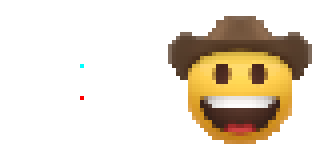

W:  64


In [3]:
#@title Seed and Target Setup {vertical-output:true}

SEED_N = 2  #@param{type:"integer"}
SEED_R = 4  #@param{type:"integer"}
TARGET = 'COWBOY'  #@param['LIZARD', 'HEART', 'SMILEY']
PADDING = 12

# emoji = {
#     'LIZARD':  '🦎',
#     'HEART':  '❤️',
#     'SMILEY': '😁'
# }[TARGET][0]
# code = hex(ord(emoji))[2:].lower()
url = '../_images/cowboy.png' #https://github.com/googlefonts/noto-emoji/blob/main/png/128/emoji_u%s.png?raw=true'%code
target = imread(url, 40)

# Show lineup
n_seed = seed(1, 40, SEED_N, SEED_R)[0, :4].permute([1, 2, 0]).cpu()
imgs = np.stack([n_seed, target], 0)
imshow(tile2d(imgs, 2))

# Format target
target[:, :, :3] *= target[:, :, 3:]
target = F.pad(torch.tensor(target).permute(2, 0, 1), [*(PADDING,)*4, 0, 0])
W = target.shape[1]

print ('W: ', W)

# Loss Legend

Select the loss function of interest from the following

* FIXED:&emsp;L2-norm loss
* INVARIANT:&emsp;Rotation-invariant loss

Select the lower and upper learning rate limits below

In [4]:
#@title Training Utilities and Setup

LOSS_FN = 'FIXED'  #@param['FIXED', 'INVARIANT']
LOWER_LR = 1e-5  #@param{type:"number"}
UPPER_LR = 1e-3  #@param{type:"number"}
MODEL_NAME = f'{MODEL_TYPE}_{TARGET}_{LOSS_FN}_{SEED_N}pt_{SEED_R}r'.lower()
MODEL_DIR = os.path.join(MODEL_PATH, MODEL_NAME)
if not os.path.exists(MODEL_DIR):
    os.mkdir(MODEL_DIR)

# if USE_DRIVE and not os.path.exists(MODEL_DIR):
#   os.mkdir(MODEL_DIR)

def fixed_loss_fn(x, scale=1e3, ax=[]):
  return scale * torch.mean(torch.square(x[:, :4] - target[:4]), ax)

def unsharp(img):
  blured = gaussian_blur(img, (5, 5), (1, 1))
  return img + (img - blured) * 2.

s = np.sqrt(3) / 2.
hex2xy = np.float32([[1., 0.], [.5, s]])
xy2hex = torch.tensor(np.linalg.inv(hex2xy))
r = torch.linspace(.5/W, 1, W//2)[:, None]
a = torch.range(0, W*np.pi) / (W / 2)
polar_xy = torch.stack([r*a.cos(), r*a.sin()], -1)[None, :]
polar_target = F.grid_sample(unsharp(target[None, :]), polar_xy)

x = torch.linspace(-1, 1, W)
y, x = torch.meshgrid(x, x)
xy_grid = torch.stack([x, y], -1)
fft_target = torch.fft.rfft(polar_target).conj()
polar_target_sqnorm = polar_target.square().sum(-1, keepdim=True)

def invariant_losses_fn(img):
  img = unsharp(img)
  polar_img = F.grid_sample(img, polar_xy.repeat(len(img), 1, 1, 1), mode='bicubic')
  x = torch.fft.rfft(polar_img)
  xy = torch.fft.irfft(x*fft_target)
  xx = polar_img.square().sum(-1, keepdim=True)
  yy = polar_target_sqnorm
  sqdiff = xx + yy - 2. * xy
  return sqdiff.mean([1, 2])

def invariant_loss_fn(img):
  return invariant_losses_fn(img).min(-1)[0].mean()

loss_fn = {
    'FIXED': fixed_loss_fn,
    'INVARIANT': invariant_loss_fn,
}[LOSS_FN]

def circle_masks(n, sz):
  x = torch.linspace(-1.0, 1.0, sz)[None, None, :]
  y = torch.linspace(-1.0, 1.0, sz)[None, :, None]
  center = -torch.rand([2, n, 1, 1]) + 0.5
  r = -0.3*torch.rand([n, 1, 1]) + 0.4
  x, y = (x-center[0])/r, (y-center[1])/r
  mask = (x*x+y*y < 1.0).float()
  return mask

model = CA()
loss_log = []
progress = 0
with torch.no_grad():
  pool = seed(256, W, SEED_N, SEED_R)
opt = torch.optim.Adam(model.parameters(), UPPER_LR)
lr_sched = torch.optim.lr_scheduler.CyclicLR(opt, LOWER_LR, UPPER_LR, step_size_up=2000, mode='triangular2', cycle_momentum=False)

print ('model name: ', MODEL_NAME)

model name:  steerable_cowboy_fixed_2pt_4r


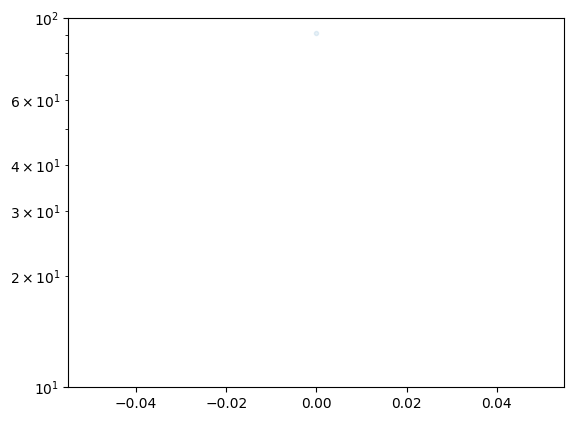

  0%|          | 0/15001 [00:00<?, ?it/s]


RuntimeError: Can't call numpy() on Tensor that requires grad. Use tensor.detach().numpy() instead.

In [5]:
#@title Training Loop {vertical-output:true}

TRAIN_MODEL = True
EPOCHS = 15000  #@param{type:"number"}
DAMAGE_RATE = 3
IMAGE_RATE = 20
INFO_RATE = 20
SAVE_RATE = 500

for _ in tqdm(range(EPOCHS+1)):
    if not TRAIN_MODEL:
        print ('skipping training')
        break
    with torch.no_grad():
        i = len(loss_log)
        batch_idx = np.random.choice(len(pool), 8, replace=False)
        x = pool[batch_idx]
        # loss_rank = torch.argsort(loss_fn(x, ax=[-2, -3, -1]), descending=True)
        # x = x[loss_rank]
        
        seed_rate = 1  if i < 4000 else 5
        if i % seed_rate == 0:
            x[:1] = seed(1, W, SEED_N, SEED_R)

        if i % DAMAGE_RATE == 0:
            damage_mask = 1. - circle_masks(1, W)[:, None]
            x[-1:] *= damage_mask

    step_n = np.random.randint(64, 96)
    overflow_loss = 0.
    diff_loss = 0.
    target_loss = 0.
    last_x = torch.zeros(x.shape)
    for _ in range(step_n):
        px = x
        x = model(x)
        diff_loss += (x - px).abs().mean()
        overflow_loss += (x - x.clamp(-2., 2.))[:, :SCALAR_CHN].square().sum()

    target_loss += loss_fn(x[:, :target.shape[0]])
    diff_loss *= 10.
    loss = target_loss + overflow_loss + diff_loss
    # if loss.isnan():
    #   # TODO: reload model from last checkpoint
    #   print('\nWARNING: NaN')
    #   pool[batch_idx] = seed(8, W, SEED_N, SEED_R)
    #   continue

    with torch.no_grad():
        loss.backward()
        for p in model.parameters():
            p.grad /= (p.grad.norm() + 1e-8)
        opt.step()
        opt.zero_grad()
        lr_sched.step()
        pool[batch_idx] = x
        loss_log.append(loss.item())

    if i % IMAGE_RATE == 0:
        clear_output(True)
        pl.plot(loss_log, '.', alpha=.1)
        pl.yscale('log')
        pl.ylim(np.min(loss_log), loss_log[0])
        pl.show()
        imgs = to_rgb(x)
        imgs = imgs.permute([0, 2, 3, 1]).cpu()
        imshow(tile2d(imgs.detach(), 4), scale=2)

    if i % INFO_RATE == 0:
        print('\rstep_n:', i, '\tloss:', loss.item(), '\tlr:', lr_sched.get_lr()[0], end='')

    if i % SAVE_RATE == 0:
        progress = i
        torch.save(model, os.path.join(MODEL_DIR, f'{MODEL_NAME}_{i}.pt'))

In [ ]:
#@title Model Demo {vertical-output:true}

FRAMES = 500  #@param{type:"integer"}
progress = 15000

model_name = f'{MODEL_TYPE}_{TARGET}_{LOSS_FN}_{SEED_N}pt_{SEED_R}r_{progress}'.lower()
model_path = os.path.join(MODEL_DIR, f'{model_name}.pt')
demo_path = os.path.join(MODEL_DIR, f'{model_name}.mp4')

try:
  model = torch.load(model_path)
  vidgen(demo_path, model, n_frames=FRAMES, p=SEED_N, r=SEED_R)
except FileNotFoundError:
  print(f'Model "{model_name}" not found.')